In [1]:
def dVm_dt_max(time, values, info):
    
    dt = time[1]-time[0]
    max_dV = (values[1]-values[0])/dt
    for i in range((np.shape(values)[0])-2):
        temp = (values[i+2]-values[i+1])/dt
        #print(temp)
        #print()
        if(temp > max_dV):
            max_dV = temp
    
    values_feature = max_dV
    
    #return time_feature, values_feature
    return None, values_feature

def V_max(time, values, info):
    
    values_feature = np.max(values)
    
    #return time_feature, values_feature
    return None, values_feature

def APD_50(time, values, info): 
    
    delta_V = np.max(values) - values[0]
    delta_V_50 = np.max(values) - delta_V*0.5
    delta_time_50 = time[-1] # Nel caso in cui non lo raggiunga (da sistemare, anche i parametri)
    pol=10 # (better to fix) just to be sure i already passed zero during polarization

    for i in range((np.shape(values)[0])-10):
        if(values[i+pol]<=delta_V_50):
            delta_time_50 = time[i+pol]
            break
            
    values_feature = delta_time_50   
            
    return None, values_feature

def APD_90(time, values, info): 
    
    delta_V = np.max(values) - values[0]
    delta_V_90 = np.max(values) - delta_V*0.9
    delta_time_90 = time[-1]
    pol=10 # (better to fix) just to be sure i already passed zero during polarization

    for i in range((np.shape(values)[0])-10):
        if(values[i+pol]<=delta_V_90):
            delta_time_90 = time[i+pol]
            break
    
    values_feature = delta_time_90
            
    return None, values_feature

def V_20(time, values, info):
    
    toi = APD_90(time, values, info)[1]*0.2 #time of interest
    pol=10 # (better to fix) just to be sure i already passed zero during polarization
    values_feature=0
    
    for i in range((np.shape(values)[0])-10):
        if(time[i+pol]>=toi):
            values_feature = values[i+pol]
            break
    
    #return time_feature, values_feature
    return None, values_feature

def V_40(time, values, info):
    
    toi = APD_90(time, values, info)[1]*0.4 #time of interest
    pol=10 # (better to fix) just to be sure i already passed zero during polarization
    values_feature=0
    
    for i in range((np.shape(values)[0])-10):
        if(time[i+pol]>=toi):
            values_feature = values[i+pol]
            break
    
    #return time_feature, values_feature
    return None, values_feature

def V_60(time, values, info):
    
    toi = APD_90(time, values, info)[1]*0.6 #time of interest
    pol=10 # (better to fix) just to be sure i already passed zero during polarization
    values_feature=0
    
    for i in range((np.shape(values)[0])-10):
        if(time[i+pol]>=toi):
            values_feature = values[i+pol]
            break
    
    #return time_feature, values_feature
    return None, values_feature

def V_80(time, values, info):
    
    toi = APD_90(time, values, info)[1]*0.8 #time of interest
    pol=10 # (better to fix) just to be sure i already passed zero during polarization
    values_feature=0
    
    for i in range((np.shape(values)[0])-10):
        if(time[i+pol]>=toi):
            values_feature = values[i+pol]
            break
    
    #return time_feature, values_feature
    return None, values_feature

def rest_Vm(time, values, info):
    
    # Da modificare quando si capisce e si modifica l'intervallo di tempo su cui operare
    values_feature = values[-1] # ultimo valore per ora
    
    #return time_feature, values_feature
    return None, values_feature

def Ca2_max(time, values, info):
    
    return None, values_feature

def get_all_keys_in_order(list_of_dicts):
    ordered_keys = []
    for dict_ in list_of_dicts:
        for key in dict_:
            if key not in ordered_keys:
                ordered_keys.append(key)
    return ordered_keys

In [2]:
import uncertainpy as un
import chaospy as cp
import numpy as np

from maleckar2 import maleckar_model

# Initialize the model
model = un.Model(run=maleckar_model,
                 labels=["Time (ms)", "Membrane potential (mV)"])

# Define a parameter dictionary
parameters_list = {
    #"V_0": -74.031982,
    #"PNa": 0.0018,
    "GK1": 3.1,
    "Gt": 8.25,
    "GKur": 2.25,
    #"GKr": 0.5,
    #"GKs": 1.0,
    "GCa_L": 6.75,
    #"Gb_Na": 0.0605,
    "Gb_Ca": 0.0590,
    "NaKMax": 68.55,
    #"KNaCa": 0.0750,
    #"ip_CaMax": 4.0,
    #"alpha_rel": 200000,
    #"tao_tr": 0.01,
    #"iupMax": 2800,
    #"Kcyca": 0.0003,
    #"Ksrca": 0.5, 
    #"Kxcs": 0.4,
    "Cm": 50,
    #"conc_Na": 140.0,
    #"conc_Ca2": 5.4,
    #"conc_K": 1.8
}

# Normalizzazione dei parametri di input
# parameters_list = {
#     #"V_0": -74.031982,
#     "PNa": 0.5,
#     "GK1": 0.5,
#     "Gt": 0.5,
#     "GKur": 0.5,
#     "GKr": 0.5,
#     "GKs": 0.5,
#     "GCa_L": 0.5,
#     "Gb_Na": 0.5,
#     "Gb_Ca": 0.5,
#     "NaKMax": 0.5,
#     "KNaCa": 0.5,
#     "ip_CaMax": 0.5,
#     "alpha_rel": 0.5,
#     "tao_tr": 0.5,
#     "iupMax": 0.5,
#     "Kcyca": 0.5,
#     "Ksrca": 0.5, 
#     "Kxcs": 0.5,
#     "Cm": 0.5,
#     "conc_Na": 0.5,
#     "conc_Ca2": 0.5,
#     "conc_K": 0.5
# }

# Create the parameters
parameters = un.Parameters(parameters_list)

# Set all parameters to have a uniform distribution
# within a 50% interval around their fixed value
parameters.set_all_distributions(un.uniform(0.5))

feature_functions = [dVm_dt_max, V_max, V_20, V_40, V_60, V_80, APD_50, APD_90, rest_Vm]

features = un.Features(
    new_features=feature_functions,
    features_to_run="all"
)

# Perform the uncertainty quantification
UQ = un.UncertaintyQuantification(model,
                                  parameters=parameters,
                                  features=features)


/home/davide_crn/miniconda3/envs/compstat2/lib/python3.8/site-packages/uncertainpy-1.2.3-py3.8.egg/uncertainpy/plotting/plot_uncertainty.py:1818: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/davide_crn/miniconda3/envs/compstat2/lib/python3.8/site-packages/uncertainpy-1.2.3-py3.8.egg/uncertainpy/plotting/plot_uncertainty.py:1818: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [3]:
# We set the seed to easier be able to reproduce the result
data = UQ.quantify(seed=10,
                   method="mc",
                   nr_mc_samples=1000)

# Con istante finale = 0.5 ci mette 20 minuti (100 timesteps)

Running model: 100%|██████████████████████████████████████████████████████████████████| 576/576 [16:22<00:00,  1.71s/it]


Saving data as: data/maleckar_model.h5


In [25]:
data = un.Data()
data.load("data_first_analysis/maleckar_model.h5")
data

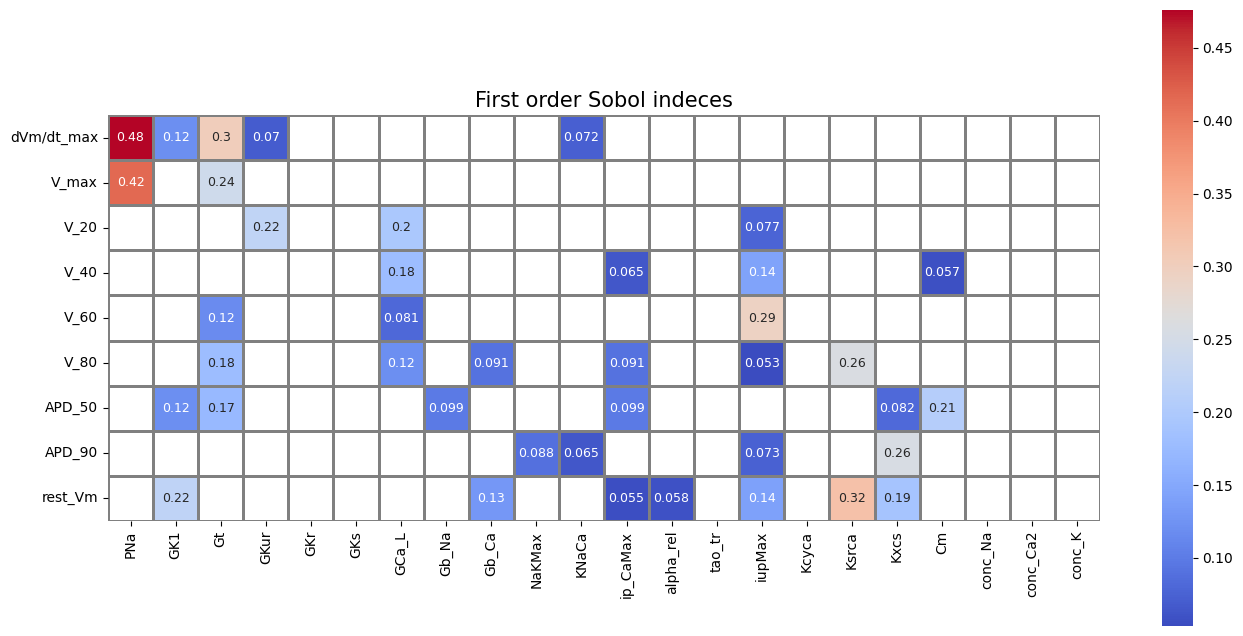

In [28]:
### SOBOL FIRST - FIRST ANALYSIS ###

import pandas as pd

# Define a parameter dictionary
parameters_list = {
    #"V_0": -74.031982,
    "PNa": 0.0018,
    "GK1": 3.1,
    "Gt": 8.25,
    "GKur": 2.25,
    "GKr": 0.5,
    "GKs": 1.0,
    "GCa_L": 6.75,
    "Gb_Na": 0.0605,
    "Gb_Ca": 0.0590,
    "NaKMax": 68.55,
    "KNaCa": 0.0750,
    "ip_CaMax": 4.0,
    "alpha_rel": 200000,
    "tao_tr": 0.01,
    "iupMax": 2800,
    "Kcyca": 0.0003,
    "Ksrca": 0.5, 
    "Kxcs": 0.4,
    "Cm": 50,
    "conc_Na": 140.0,
    "conc_Ca2": 5.4,
    "conc_K": 1.8
}

df = pd.DataFrame({#'V_membrane':data["maleckar_model"].sobol_first_average, 
                   'dVm/dt_max':data["dVm_dt_max"].sobol_first_average, 
                   'V_max':data["V_max"].sobol_first,
                   'V_20':data["V_20"].sobol_first,
                   'V_40':data["V_40"].sobol_first,
                   'V_60':data["V_60"].sobol_first,
                   'V_80':data["V_80"].sobol_first,
                   'APD_50':data["APD_50"].sobol_first, 
                   'APD_90':data["APD_90"].sobol_first,
                   'rest_Vm':data["rest_Vm"].sobol_first})
df = df.transpose()
df.columns = get_all_keys_in_order([parameters_list])

import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(16, 8))
mask = np.array(df < 0.05)

ax = sns.heatmap(df, linewidth=0.8, annot=True, square=True, ax=ax, 
                 cmap='coolwarm', annot_kws={"fontsize": 9}, mask=mask,
                 linecolor='grey')
ax.set_title("First order Sobol indeces", fontsize=15)

plt.show()

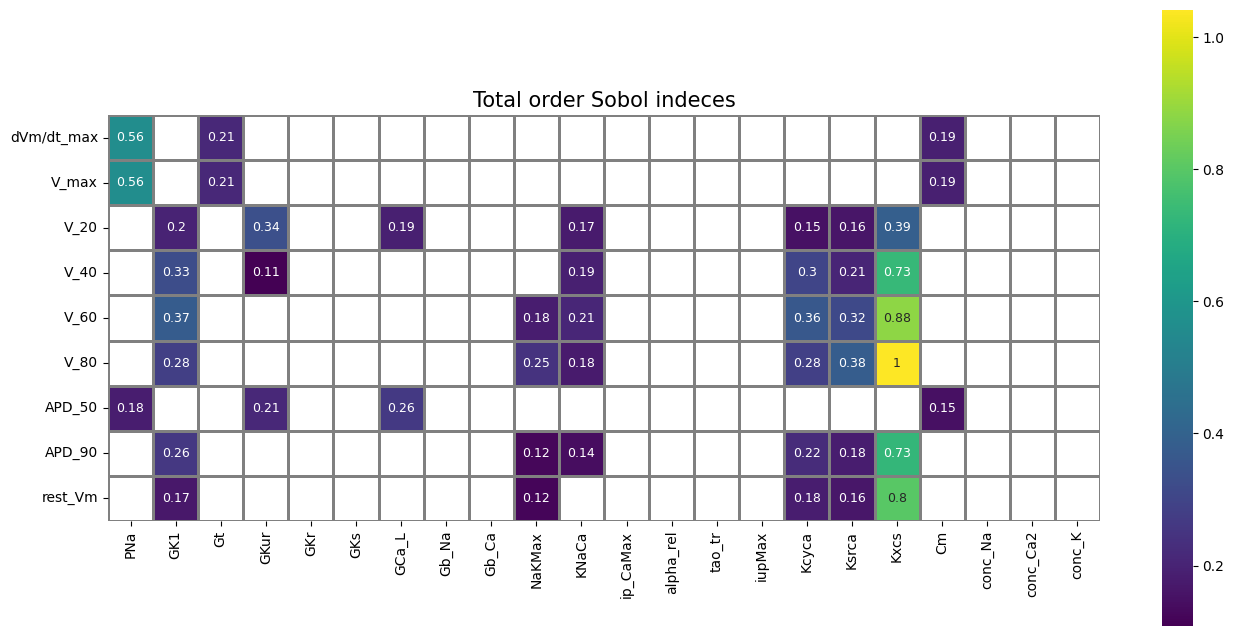

In [30]:
### SOBOL TOTAL - FIRST ANALYSIS ###

import pandas as pd
matrix = np.array([data["V_max"].sobol_first, data["dVm_dt_max"].sobol_first])
matrix

df = pd.DataFrame({'dVm/dt_max':data["dVm_dt_max"].sobol_total, 
                   'V_max':data["V_max"].sobol_total,
                   'V_20':data["V_20"].sobol_total,
                   'V_40':data["V_40"].sobol_total,
                   'V_60':data["V_60"].sobol_total,
                   'V_80':data["V_80"].sobol_total,
                   'APD_50':data["APD_50"].sobol_total, 
                   'APD_90':data["APD_90"].sobol_total,
                   'rest_Vm':data["rest_Vm"].sobol_total})
df = df.transpose()
df.columns = get_all_keys_in_order([parameters_list])

import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(16, 8))
mask = np.array(abs(df) < 0.1)

ax = sns.heatmap(df, linewidth=0.8, annot=True, square=True, ax=ax, 
                 cmap='viridis', annot_kws={"fontsize": 9}, mask=mask,
                 linecolor='grey')
ax.set_title("Total order Sobol indeces", fontsize=15)

plt.show()

In [32]:
data = un.Data()
data.load("data/maleckar_model.h5")
data

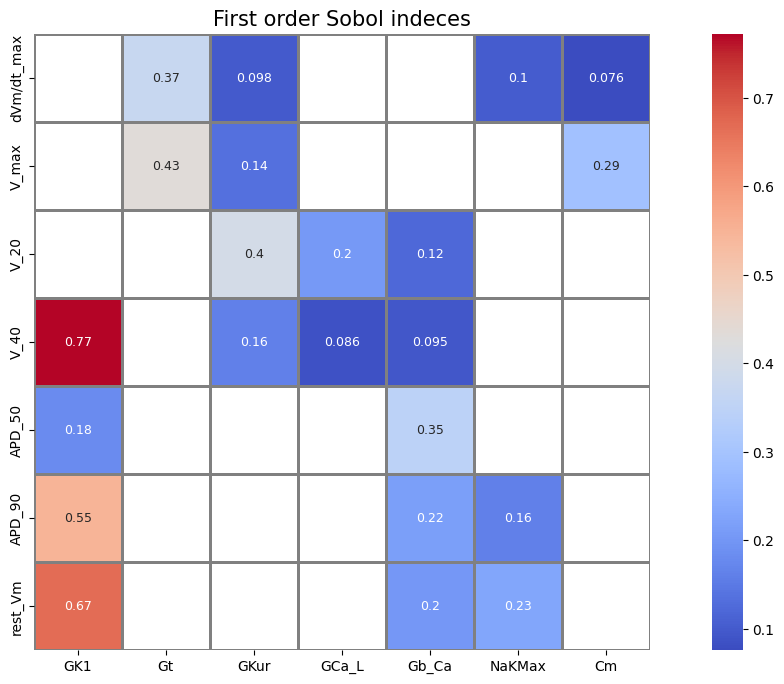

In [37]:
### SOBOL FIRST - SECOND ANALYSIS ###

import pandas as pd

parameters_list = {
    #"V_0": -74.031982,
    #"PNa": 0.0018,
    "GK1": 3.1,
    "Gt": 8.25,
    "GKur": 2.25,
    #"GKr": 0.5,
    #"GKs": 1.0,
    "GCa_L": 6.75,
    #"Gb_Na": 0.0605,
    "Gb_Ca": 0.0590,
    "NaKMax": 68.55,
    #"KNaCa": 0.0750,
    #"ip_CaMax": 4.0,
    #"alpha_rel": 200000,
    #"tao_tr": 0.01,
    #"iupMax": 2800,
    #"Kcyca": 0.0003,
    #"Ksrca": 0.5, 
    #"Kxcs": 0.4,
    "Cm": 50,
    #"conc_Na": 140.0,
    #"conc_Ca2": 5.4,
    #"conc_K": 1.8
}

df = pd.DataFrame({#'V_membrane':data["maleckar_model"].sobol_first_average, 
                   'dVm/dt_max':data["dVm_dt_max"].sobol_first_average, 
                   'V_max':data["V_max"].sobol_first,
                   'V_20':data["V_20"].sobol_first,
                   'V_40':data["V_40"].sobol_first,
                   #'V_60':data["V_60"].sobol_first,
                   #'V_80':data["V_80"].sobol_first,
                   'APD_50':data["APD_50"].sobol_first, 
                   'APD_90':data["APD_90"].sobol_first,
                   'rest_Vm':data["rest_Vm"].sobol_first})
df = df.transpose()
df.columns = get_all_keys_in_order([parameters_list])

import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(16, 8))
mask = np.array(df < 0.05)

ax = sns.heatmap(df, linewidth=0.8, annot=True, square=True, ax=ax, 
                 cmap='coolwarm', annot_kws={"fontsize": 9}, mask=mask,
                 linecolor='grey')
ax.set_title("First order Sobol indeces", fontsize=15)

plt.show()

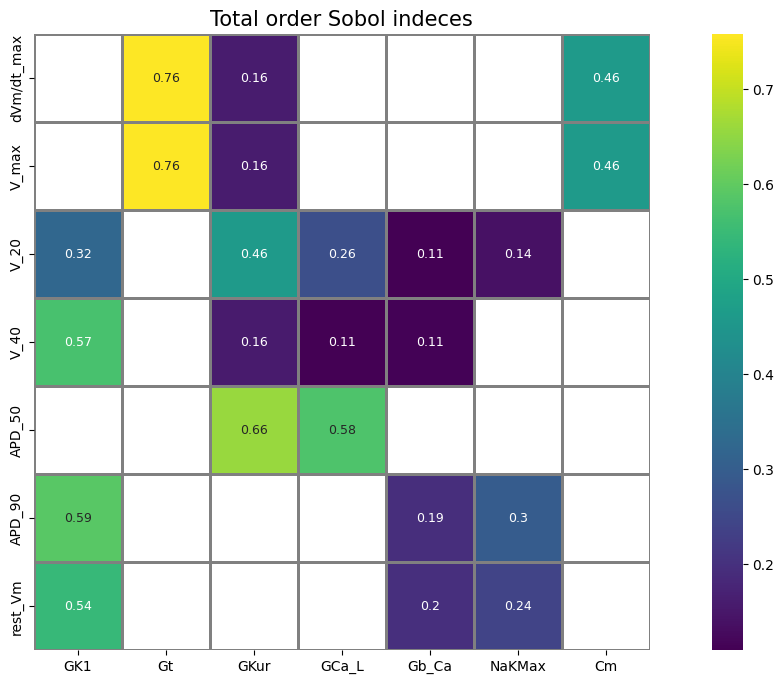

In [36]:
### SOBOL TOTAL - SECOND ANALYSIS ###

import pandas as pd
matrix = np.array([data["V_max"].sobol_first, data["dVm_dt_max"].sobol_first])
matrix

df = pd.DataFrame({'dVm/dt_max':data["dVm_dt_max"].sobol_total, 
                   'V_max':data["V_max"].sobol_total,
                   'V_20':data["V_20"].sobol_total,
                   'V_40':data["V_40"].sobol_total,
                   #'V_60':data["V_60"].sobol_total,
                   #'V_80':data["V_80"].sobol_total,
                   'APD_50':data["APD_50"].sobol_total, 
                   'APD_90':data["APD_90"].sobol_total,
                   'rest_Vm':data["rest_Vm"].sobol_total})
df = df.transpose()
df.columns = get_all_keys_in_order([parameters_list])

import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(16, 8))
mask = np.array(abs(df) < 0.1)

ax = sns.heatmap(df, linewidth=0.8, annot=True, square=True, ax=ax, 
                 cmap='viridis', annot_kws={"fontsize": 9}, mask=mask,
                 linecolor='grey')
ax.set_title("Total order Sobol indeces", fontsize=15)

plt.show()

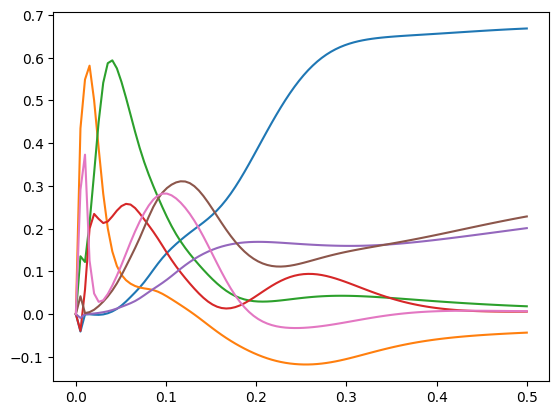

In [21]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(np.shape(data["maleckar_model"].sobol_first)[0]):
    #print(np.shape(data["maleckar_model"].sobol_total))
    plt.plot(time,data["maleckar_model"].sobol_first[i])

In [ ]:
df

In [ ]:
print(data["APD_50"].evaluations)

In [20]:
voi = np.linspace(0, 0.5, 100)

    # Construct ODE object to solve
time = voi

In [17]:
time, values, info = maleckar_model( #V_0=-74.031982,
                    PNa=0.0018,
                    GK1=3.1,
                    Gt=8.25,
                    GKur=2.25,
                    GKr=0.5,
                    GKs=1.0,
                    GCa_L=6.75,
                    Gb_Na=0.0605,
                    Gb_Ca=0.0590,
                    NaKMax=68.55,
                    KNaCa=0.0750,
                    ip_CaMax=4.0,
                    alpha_rel=200000,
                    tao_tr=0.01,
                    iupMax=2800,
                    Kcyca=0.0003,
                    Ksrca=0.5, 
                    Kxcs=0.4,
                    Cm=50,
                    conc_Na=140.0,
                    conc_Ca2=5.4,
                    conc_K=1.8 )
#print(time)
#print(values)
#print(info)
print(np.shape(time))
print(np.shape(values))

TypeError: maleckar_model() got an unexpected keyword argument 'PNa'

In [13]:
def denormalize(value, min_value, max_value):
    return (value * (max_value - min_value)) + min_value

denormalize(0.6, 34.27, 102.82)

75.39999999999999

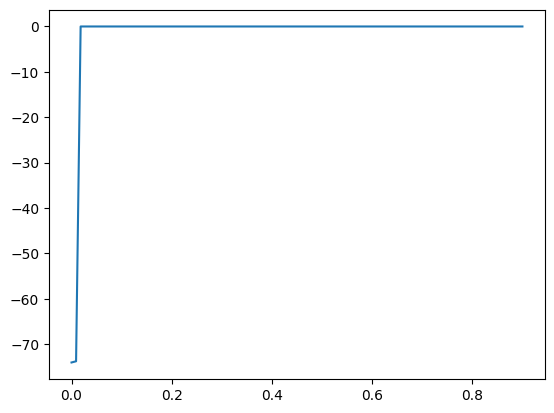

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(time,values)